In [234]:
import os
from pathlib import Path, PureWindowsPath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm

#Packages related to clustering
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from prince import FAMD
from sklearn.cluster import KMeans
import gzip, pickle, pickletools

In [235]:
#! pip install tslearn
#! pip install prince

In [236]:
os.path.dirname(os.getcwd())

'C:\\Users\\Cornelius\\Cory Dropbox\\Cory LeRoy\\PC\\Documents\\GitHub\\Store-Sales'

In [237]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd

WindowsPath('C:/Users/Cornelius/Cory Dropbox/Cory LeRoy/PC/Documents/GitHub/Store-Sales')

In [238]:
path = path_cwd / 'data'
path

WindowsPath('C:/Users/Cornelius/Cory Dropbox/Cory LeRoy/PC/Documents/GitHub/Store-Sales/data')

In [239]:
df_train = pd.read_csv(path / 'raw/train.csv')
df_transaction = pd.read_csv(path / 'raw/transactions.csv')
df_holidays = pd.read_csv(path / 'raw/holidays_events.csv')
df_oil = pd.read_csv(path / 'raw/oil.csv')
df_stores = pd.read_csv(path / 'raw/stores.csv')
df_test = pd.read_csv(path / 'raw/test.csv')

In [240]:
df_stores['cluster'].unique().shape
df_train['date'].max()

'2017-08-15'

In [241]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [242]:
df_oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


## Clean Data ##

In [243]:
#rename oil to be used for missing value interpolation
new_oil = df_oil.copy()
new_oil.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

In [244]:
# Assuming df is your DataFrame and 'column_name' is the name of the column
null_count = new_oil['oil_price'].isnull().sum()

# This will give you the count of null values in the 'column_name' column
print("Count of null values in 'oil_price':", null_count)

Count of null values in 'oil_price': 43


In [245]:
new_oil['oil_price'] = new_oil['oil_price'].interpolate(method='index')

In [246]:
# Assuming df is your DataFrame and 'column_name' is the name of the column
null_count = new_oil['oil_price'].isnull().sum()

# This will give you the count of null values in the 'column_name' column
print("Count of null values in 'oil_price':", null_count)

Count of null values in 'oil_price': 1


In [247]:
new_oil.at[0, 'oil_price'] = 93.14

In [248]:
# Assuming df is your DataFrame and 'column_name' is the name of the column
null_count = new_oil['oil_price'].isnull().sum()

# This will give you the count of null values in the 'column_name' column
print("Count of null values in 'oil_price':", null_count)

Count of null values in 'oil_price': 0


#### shorten date ####

In [249]:
def train_to_store_merge(train, store):
    df_train_store_merged = pd.merge(train, store, how='left', on='store_nbr')
    return df_train_store_merged

In [250]:
# train clean

df_train['date'] = pd.to_datetime(df_train['date'])
first_sale_date_per_store = df_train[df_train['sales'] > 0].groupby('store_nbr')['date'].min().reset_index()

# remove rows before stores were open. only do this to train
df_train_min_date = pd.merge(df_train, first_sale_date_per_store, on='store_nbr')
df_train_shortened = df_train_min_date[df_train_min_date['date_x'] >= df_train_min_date['date_y']] 
df_train_shortened = df_train_shortened.drop(['date_y'], axis=1)
df_train_shortened.rename(columns={'date_x':'date'}, inplace=True)
df_train_shortened = train_to_store_merge(df_train_shortened, df_stores)

# remove dates when stores were temporarily closed
df_train_short = df_train_shortened[~((df_train_shortened['date']>='2016-08-22') &(df_train_shortened['date']<='2016-10-26') &(df_train_shortened['store_nbr']==25))]
df_train_short =df_train_short[~((df_train_short['date']>='2014-04-14') &(df_train_short['date']<='2014-07-23') &(df_train_short['store_nbr']==24))]
df_train_short =df_train_short[~((df_train_short['date']>='2013-07-08') &(df_train_short['date']<='2013-07-30') &(df_train_short['store_nbr']==30))]
df_train_short =df_train_short[~((df_train_short['date']>='2014-08-04') &(df_train_short['date']<='2014-09-10') &(df_train_short['store_nbr']==14))]
df_train_short =df_train_short[~((df_train_short['date']>='2015-03-30') &(df_train_short['date']<='2015-05-28') &(df_train_short['store_nbr']==12))]
df_train_shortened =df_train_short[~((df_train_short['date']>='2016-08-15') &(df_train_short['date']<='2016-12-02') &(df_train_short['store_nbr']==18))]

In [251]:
def create_date_features(df):
    df_train['date'] = pd.to_datetime(df_train['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    return df

#### holidays feature eng ####

In [252]:
# holidays 

df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_holidays_real = df_holidays[df_holidays['transferred']==False] 

#unique_holis2 = df_holidays_real['description'].drop_duplicates()
unique_holis2 = df_holidays_real[['description','locale']].drop_duplicates()
unique_holis_national = unique_holis2[unique_holis2['locale']=='National'].drop(['locale'],axis=1)
unique_holis_city = unique_holis2[unique_holis2['locale']=='Local'].drop(['locale'],axis=1)
unique_holis_state = unique_holis2[unique_holis2['locale']=='Regional'].drop(['locale'],axis=1)

national_holidays = df_holidays_real[df_holidays_real['locale']=='National'].loc[:,('date','description')]
local_holidays = df_holidays_real[df_holidays_real['locale']=='Local'].loc[:,('date','description','locale_name')]
state_holidays = df_holidays_real[df_holidays_real['locale']=='Regional'].loc[:,('date','description','locale_name')]

df_train_summed_daily = df_train_shortened.groupby(['date','city','state']).agg({'onpromotion':'sum', 'sales':'sum'}).reset_index()


In [253]:
df_holi = pd.merge(df_train_summed_daily, national_holidays, how='left', on='date')
df_holi = pd.merge(df_holi, state_holidays, how='left', left_on=['date', 'state'], right_on=['date','locale_name'])
df_holi = pd.merge(df_holi, local_holidays, how='left', left_on=['date', 'city'], right_on=['date','locale_name'])

df_holi = df_holi.drop(['locale_name_x','locale_name_y'],axis=1)
df_holi = df_holi.rename(columns = {'description_x':'national_holiday','description_y':'state_holiday','description':'city_holiday'})

In [254]:
# set boolean column for each unique holiday. still have dups

for holiday in unique_holis_national['description'].tolist():
    df_holi[holiday] = df_holi['national_holiday'] == holiday
for holiday in unique_holis_state['description'].tolist():
    df_holi[holiday] = df_holi['state_holiday'] == holiday
for holiday in unique_holis_city['description'].tolist():
    df_holi[holiday] = df_holi['city_holiday'] == holiday

df_holi = df_holi.drop(['national_holiday','state_holiday','city_holiday'] ,axis=1)

C:\Users\Cornelius\AppData\Local\Temp\ipykernel_21228\194147805.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_holi[holiday] = df_holi['city_holiday'] == holiday
C:\Users\Cornelius\AppData\Local\Temp\ipykernel_21228\194147805.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_holi[holiday] = df_holi['city_holiday'] == holiday
C:\Users\Cornelius\AppData\Local\Temp\ipykernel_21228\194147805.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [255]:
# combines duplicates rows into 1 rows where there is a true for each holiday that falls on the given date
unique_holis_list = list(unique_holis2['description'])
agg_func = {col: 'any' for col in unique_holis_list}

aggregated_df = df_holi.groupby(['date', 'sales', 'city', 'state', 'onpromotion']).agg(agg_func).reset_index()


aggregated_df = pd.get_dummies(aggregated_df, columns=['city', 'state'], prefix=['city', 'state'])

In [256]:
#OLS to determine impact of each holiday across all stores

In [257]:
# seasonality has big impact on predicted sales so need to add some variables to capture 
aggregated_df_ols = aggregated_df.copy()
aggregated_df_ols['dow'] = aggregated_df_ols['date'].dt.dayofweek
aggregated_df_ols['month'] = aggregated_df_ols['date'].dt.month
aggregated_df_ols['year'] = aggregated_df_ols['date'].dt.year
aggregated_df_ols = aggregated_df_ols.drop('date',axis=1)

In [258]:
#model seasonality with dummy vars... do i need this?
aggregated_df_ols_dummies =  pd.get_dummies(aggregated_df_ols, columns=['dow','month', 'year'], drop_first=True)

#### add oil interpolated, lag_1, rolling mean ####

In [259]:
def add_lag_rolling(aggregated_df_ols_dummies):
# lag 1 and rolling mean do not look at correct values         
# Lag sales by 1 to get previous day of sales value
    aggregated_df_ols_dummies['lag_1'] = aggregated_df_ols_dummies['sales'].shift(1)

# Add rolling mean for 7-day window
    aggregated_df_ols_dummies['rolling_mean'] = aggregated_df_ols_dummies['sales'].rolling(window=7).mean()


    aggregated_df_ols_dummies['lag_1'].fillna(aggregated_df_ols_dummies['sales'], inplace=True)
    aggregated_df_ols_dummies['rolling_mean'].fillna(aggregated_df_ols_dummies['sales'],inplace=True)
    return aggregated_df_ols_dummies

In [260]:
aggregated_df_ols_dummies = add_lag_rolling(aggregated_df_ols_dummies)

In [261]:
aggregated_df_ols_dummies

,sales,onpromotion,Fundacion de Manta,Provincializacion de Cotopaxi,Fundacion de Cuenca,Cantonizacion de Libertad,Cantonizacion de Riobamba,Cantonizacion del Puyo,Cantonizacion de Guaranda,Provincializacion de Imbabura,...,month_9,month_10,month_11,month_12,year_2014,year_2015,year_2016,year_2017,lag_1,rolling_mean
0,2511.618999,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2511.618999,2511.618999
1,2978.224000,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2511.618999,2978.224000
2,4973.285000,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2978.224000,4973.285000
3,5316.224000,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,4973.285000,5316.224000
4,5615.389008,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,5316.224000,5615.389008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35272,28950.659000,394,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,26808.235000,21080.268572
35273,30309.081000,621,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,28950.659000,23269.231286
35274,35793.972976,605,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,30309.081000,26187.106854
35275,101063.805991,1682,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,35793.972976,38414.810996


In [262]:
aggregated_df_ols_dummies.iloc[:, 140:]

,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,month_2,...,month_9,month_10,month_11,month_12,year_2014,year_2015,year_2016,year_2017,lag_1,rolling_mean
0,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2511.618999,2511.618999
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2511.618999,2978.224000
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2978.224000,4973.285000
3,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,4973.285000,5316.224000
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,5316.224000,5615.389008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35272,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,26808.235000,21080.268572
35273,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,28950.659000,23269.231286
35274,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,30309.081000,26187.106854
35275,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,35793.972976,38414.810996


In [263]:
#### OLS for holiday reduction ####
X = aggregated_df_ols_dummies.drop('sales',axis=1)
# add constant for linear regression
X = sm.add_constant(X)
X = X.astype(int)
y=aggregated_df_ols_dummies['sales']

In [264]:
model_OLS = sm.OLS(y,X).fit()
model_summary = model_OLS.summary()

In [265]:
# remove features that have p value >.10 
# ... no xmas day in trainset
pvalues = model_OLS.pvalues
alpha = .05
drop_columns = pvalues.to_frame(name='feature').reset_index()
drop_columns = drop_columns[(~drop_columns['index'].str.contains('city')) \
                            & (~drop_columns['index'].str.contains('month')) \
                            & (~drop_columns['index'].str.contains('year')) \
                            & (~drop_columns['index'].str.contains('state')) \
                            & (drop_columns['feature']>alpha) \
                           ]
#drop_columns = pvalues[(pvalues>alpha)]
drop_cols = list(drop_columns['index'])
drop_cols

['Fundacion de Manta',
 'Provincializacion de Cotopaxi',
 'Fundacion de Cuenca',
 'Cantonizacion de Libertad',
 'Cantonizacion de Riobamba',
 'Cantonizacion del Puyo',
 'Cantonizacion de Guaranda',
 'Provincializacion de Imbabura',
 'Cantonizacion de Latacunga',
 'Fundacion de Machala',
 'Fundacion de Santo Domingo',
 'Cantonizacion de El Carmen',
 'Cantonizacion de Cayambe',
 'Fundacion de Esmeraldas',
 'Primer Grito de Independencia',
 'Fundacion de Riobamba',
 'Fundacion de Ambato',
 'Fundacion de Ibarra',
 'Cantonizacion de Quevedo',
 'Traslado Independencia de Guayaquil',
 'Dia de Difuntos',
 'Provincializacion de Santo Domingo',
 'Provincializacion Santa Elena',
 'Independencia de Guaranda',
 'Independencia de Latacunga',
 'Independencia de Ambato',
 'Fundacion de Quito-1',
 'Fundacion de Loja',
 'Puente Navidad',
 'Navidad',
 'Navidad+1',
 'Puente Primer dia del ano',
 'Primer dia del ano-1',
 'Recupero puente Navidad',
 'Recupero puente primer dia del ano',
 'Viernes Santo',
 '

In [266]:
#values2 = pd.DataFrame(pvalues).reset_index()
#pvalues2.rename(columns={'index':'holiday',0:'p'} , inplace=True)
#pvalues2

In [267]:
print(len(drop_cols), 'holidays dropped out of', len(unique_holis2),'.', len(unique_holis2)-len(drop_cols) ,'unique holidays remain' )

85 holidays dropped out of 103 . 18 unique holidays remain


In [268]:
df_holi_shortened = df_holidays_real[~df_holidays_real['description'].isin(drop_cols)]
df_holi_shortened = df_holi_shortened.drop(['type','locale','locale_name','transferred'],axis=1)

In [269]:
# unique holidays from the reduced holidays list
unique_holidays = df_holi_shortened['description'].unique()
filtered_holidays = df_holidays[df_holidays['description'].isin(unique_holidays)]

In [270]:
#separate these out because they have differenct merge conditions
national_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='National'].loc[:,('date','description')]
local_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='Local'].loc[:,('date','description','locale_name')]
state_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='Regional'].loc[:,('date','description','locale_name')]

In [271]:
# unique holidays from the reduced holidays list
unique_holidays = df_holi_shortened['description'].unique()

#### merge train to holidays ####

In [272]:
# unique holidays from the reduced holidays list
filtered_holidays = df_holidays[df_holidays['description'].isin(unique_holidays)]
#separate locales out because they have differenct merge conditions
national_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='National'].loc[:,('date','description')]
local_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='Local'].loc[:,('date','description','locale_name')]
state_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='Regional'].loc[:,('date','description','locale_name')]

In [273]:
local_holidays_filtered

,date,description,locale_name
29,2012-12-06,Fundacion de Quito,Quito
32,2012-12-22,Cantonizacion de Salinas,Salinas
82,2013-12-06,Fundacion de Quito,Quito
86,2013-12-22,Cantonizacion de Salinas,Salinas
147,2014-12-06,Fundacion de Quito,Quito
151,2014-12-22,Cantonizacion de Salinas,Salinas
201,2015-12-06,Fundacion de Quito,Quito
205,2015-12-22,Cantonizacion de Salinas,Salinas
287,2016-12-06,Fundacion de Quito,Quito
291,2016-12-22,Cantonizacion de Salinas,Salinas


In [274]:
def train_to_holiday_merge(train, national_holidays_filtered, state_holidays_filtered, local_holidays_filtered):
    #train['date'] = pd.to_datetime(train['date'])
    df_train_filtered = pd.merge(train, national_holidays_filtered, how='left', on='date')
    df_train_filtered = pd.merge(df_train_filtered, state_holidays_filtered, how='left', left_on=['date', 'state'], right_on=['date','locale_name'])
    df_train_filtered = pd.merge(df_train_filtered, local_holidays_filtered, how='left', left_on=['date', 'city'], right_on=['date','locale_name'])
    df_train_filtered['holiday'] = df_train_filtered['description_x'].combine_first(df_train_filtered['description_y']).combine_first(df_train_filtered['description'])

    df_train_filtered = df_train_filtered.drop(['locale_name_x','locale_name_y','description','description_x','description_y'],axis=1)
    return df_train_filtered

In [275]:
def train_to_oil_merge(train, oil):
    oil['date'] = pd.to_datetime(oil['date'])
    df = pd.merge(train,oil, how='left', on='date')
    return df

In [276]:
df_train_filtered = train_to_holiday_merge(df_train_shortened, national_holidays_filtered, state_holidays_filtered,local_holidays_filtered)
df_train_filtered

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,Quito,Pichincha,D,13,NaN
1,1783,2013-01-02,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN
2,1784,2013-01-02,1,BEAUTY,2.000,0,Quito,Pichincha,D,13,NaN
3,1785,2013-01-02,1,BEVERAGES,1091.000,0,Quito,Pichincha,D,13,NaN
4,1786,2013-01-02,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2765692,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,NaN
2765693,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,NaN
2765694,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,NaN
2765695,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,NaN


In [277]:
#### combine train ####
df_train_filtered = train_to_holiday_merge(df_train_shortened, national_holidays_filtered, state_holidays_filtered,local_holidays_filtered)
df_train_filtered = create_date_features(df_train_filtered)
df_train_merged = train_to_oil_merge(df_train_filtered, new_oil)

#df_train_merged = df_train_merged.drop(['id','city','state', 'type'], axis=1)
df_train_merged = df_train_merged.drop(['city','state', 'type'], axis=1)


In [278]:
oil_missing = df_train_merged[df_train_merged['oil_price'].isna()]
print(oil_missing['date'].unique().shape[0], 'completely missing dates')

481 completely missing dates


In [279]:
oil_missing[oil_missing['oil_price'].isna()]

,id,date,store_nbr,family,sales,onpromotion,cluster,holiday,day_of_week,month,year,oil_price
99,7128,2013-01-05,1,AUTOMOTIVE,5.000,0,13,NaN,5,1,2013,NaN
100,7129,2013-01-05,1,BABY CARE,0.000,0,13,NaN,5,1,2013,NaN
101,7130,2013-01-05,1,BEAUTY,3.000,0,13,NaN,5,1,2013,NaN
102,7131,2013-01-05,1,BEVERAGES,1160.000,0,13,NaN,5,1,2013,NaN
103,7132,2013-01-05,1,BOOKS,0.000,0,13,NaN,5,1,2013,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2765626,2997319,2017-08-13,9,POULTRY,412.458,0,6,NaN,6,8,2017,NaN
2765627,2997320,2017-08-13,9,PREPARED FOODS,105.169,1,6,NaN,6,8,2017,NaN
2765628,2997321,2017-08-13,9,PRODUCE,1693.607,7,6,NaN,6,8,2017,NaN
2765629,2997322,2017-08-13,9,SCHOOL AND OFFICE SUPPLIES,200.000,8,6,NaN,6,8,2017,NaN


In [280]:
# df_oil is completely missing some days. after left joining, need to interpolate again
df_train_merged['oil_price'] = df_train_merged['oil_price'].interpolate(method='index')
#new_oil['oil_price'] = new_oil['oil_price'].interpolate(method='index')

In [281]:
df_train_merged['family'].unique().shape

(33,)

In [282]:
df_train_merged[df_train_merged['holiday'].notnull()].head(5)

,id,date,store_nbr,family,sales,onpromotion,cluster,holiday,day_of_week,month,year,oil_price
1320,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,13,Carnaval,0,2,2013,97.01
1321,73063,2013-02-11,1,BABY CARE,0.0,0,13,Carnaval,0,2,2013,97.01
1322,73064,2013-02-11,1,BEAUTY,0.0,0,13,Carnaval,0,2,2013,97.01
1323,73065,2013-02-11,1,BEVERAGES,172.0,0,13,Carnaval,0,2,2013,97.01
1324,73066,2013-02-11,1,BOOKS,0.0,0,13,Carnaval,0,2,2013,97.01


In [283]:
#scale numeric columns
columns_to_scale = ['onpromotion','oil_price']
# Introduce MinMaxScaler for primary FE 
scaler = MinMaxScaler()

# Apply
df_train_merged[columns_to_scale] = scaler.fit_transform(df_train_merged[columns_to_scale])
df_train_merged

,id,date,store_nbr,family,sales,onpromotion,cluster,holiday,day_of_week,month,year,oil_price
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0.000000,13,NaN,2,1,2013,0.792965
1,1783,2013-01-02,1,BABY CARE,0.000,0.000000,13,NaN,2,1,2013,0.792965
2,1784,2013-01-02,1,BEAUTY,2.000,0.000000,13,NaN,2,1,2013,0.792965
3,1785,2013-01-02,1,BEVERAGES,1091.000,0.000000,13,NaN,2,1,2013,0.792965
4,1786,2013-01-02,1,BOOKS,0.000,0.000000,13,NaN,2,1,2013,0.792965
...,...,...,...,...,...,...,...,...,...,...,...,...
2765692,3000883,2017-08-15,9,POULTRY,438.133,0.000000,6,NaN,1,8,2017,0.253228
2765693,3000884,2017-08-15,9,PREPARED FOODS,154.553,0.001350,6,NaN,1,8,2017,0.253228
2765694,3000885,2017-08-15,9,PRODUCE,2419.729,0.199730,6,NaN,1,8,2017,0.253228
2765695,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,0.010796,6,NaN,1,8,2017,0.253228


### K Means ###

In [284]:
# shape data to feed into TimeSeriesKmeans
df_daily_sales_by_family = df_train_merged.groupby(['date', 'family'])['sales'].sum().reset_index()

# Convert date column to datetime if it's not already in datetime format
df_daily_sales_by_family['date'] = pd.to_datetime(df_daily_sales_by_family['date'])
# Pivot the data
df_pivot = df_daily_sales_by_family.pivot(index='date', columns='family', values='sales').fillna(0)

df_pivot = df_pivot.T # remove pivot to see what happens
XTrain = df_pivot.to_numpy()
#XTrain = df_pivot.to_numpy().reshape(-1, df_pivot.shape[0] , df_pivot.shape[1])
#XTrain = df_pivot.to_numpy().reshape(df_pivot.shape[1], df_pivot.shape[0] , 1)
XCategories = df_pivot.index

seed = 0
np.random.seed(seed)
x_train = TimeSeriesScalerMeanVariance().fit_transform(XTrain)
sz=x_train.shape[1]


In [302]:
#Try different n_clusters to help set that parameter. SLOW DO NOT RUN
inertia = []
silhouette_scores = []
for k in range(2, 32):  # Try different values of k from 2 to 10
    km = TimeSeriesKMeans(n_clusters=k, verbose=False, random_state=seed)
    y_pred_km = km.fit_predict(x_train)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(x_train, km.labels_))


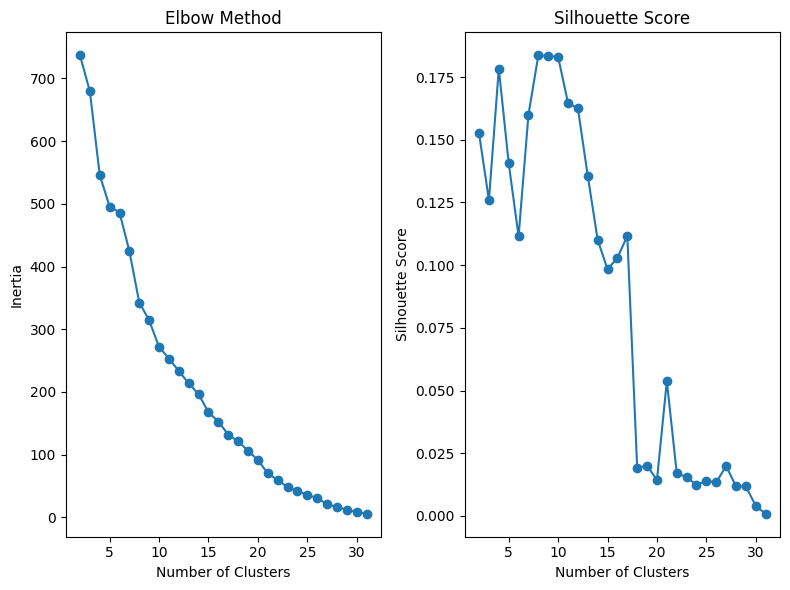

In [303]:
#ALSO USED TO CHOOSE CLUSTERS PARAMETER Plot inertia and silhouette scores. look for elbow point or max silhouette score
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 32), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(range(2, 32), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()

In [285]:
# look for elbow in inertia and peak in silhouette

In [286]:
df_daily_sales_by_family = df_train_merged.groupby(['date', 'family'])['sales'].sum().reset_index()

# Convert date column to datetime if it's not already in datetime format
df_daily_sales_by_family['date'] = pd.to_datetime(df_daily_sales_by_family['date'])

# Pivot the data
df_pivot = df_daily_sales_by_family.pivot(index='date', columns='family', values='sales').fillna(0)

df_pivot = df_pivot.T #remove pivot to see what happens

XTrain = df_pivot.to_numpy() #.reshape(-1, df_pivot.shape[0] , df_pivot.shape[1])
XCategories = df_pivot.index
#XCategories = df_pivot.columns


seed = 0
np.random.seed(seed)
x_train = TimeSeriesScalerMeanVariance().fit_transform(XTrain)
sz=x_train.shape[1]

n_clusters = 6
sz = x_train.shape[1]

km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred_km = km.fit_predict(x_train)

In [287]:
myDict = {}

for i in range(len(XCategories)):
    key = XCategories[i]
    value = y_pred_km[i]
    myDict[key] = value


def familyCluster(fam):
    return myDict.get(fam)

df_train_merged['familycluster'] = df_train_merged['family'].apply(lambda x: familyCluster(x))

#### FbProphet fe ####

In [288]:
df_train_dummies_fb = df_train_merged.copy()
df_train_dummies_fb = df_train_dummies_fb[['date','sales','family','familycluster', 'store_nbr']]
df_train_dummies_fb = df_train_dummies_fb.sort_values(by='date')
df_train_dummies_fb

,date,sales,family,familycluster,store_nbr
844600,2013-01-01,0.00,SCHOOL AND OFFICE SUPPLIES,5,25
844576,2013-01-01,186.00,CLEANING,5,25
844577,2013-01-01,143.00,DAIRY,5,25
844578,2013-01-01,71.09,DELI,5,25
844579,2013-01-01,46.00,EGGS,5,25
...,...,...,...,...,...
1370482,2017-08-15,226.00,PERSONAL CARE,5,33
1370483,2017-08-15,4.00,PET SUPPLIES,0,33
1370484,2017-08-15,3.00,PLAYERS AND ELECTRONICS,0,33
1370477,2017-08-15,0.00,LAWN AND GARDEN,5,33


In [289]:
##dummy variables for holiday
df_train_merged = df_train_merged.sort_values(by=['date'])
df_train_dummies = pd.get_dummies(df_train_merged, columns=['holiday']) ## add family pca here maybe?

### fb prophet fe ###

In [290]:
df_train_dummies_fb = df_train_merged.copy()
df_train_dummies_fb = df_train_dummies_fb[['date','sales','family','familycluster', 'store_nbr']]
df_train_dummies_fb = df_train_dummies_fb.sort_values(by='date')
df_train_dummies_fb

,date,sales,family,familycluster,store_nbr
844600,2013-01-01,0.0,SCHOOL AND OFFICE SUPPLIES,5,25
844570,2013-01-01,0.0,BABY CARE,0,25
844571,2013-01-01,2.0,BEAUTY,5,25
844599,2013-01-01,0.0,PRODUCE,0,25
844569,2013-01-01,0.0,AUTOMOTIVE,5,25
...,...,...,...,...,...
548507,2017-08-15,1.0,HARDWARE,4,18
548500,2017-08-15,606.0,CLEANING,5,18
548501,2017-08-15,569.0,DAIRY,5,18
220160,2017-08-15,0.0,HOME APPLIANCES,2,12


### sarima fe ###

In [291]:
df_train_dummies_s = df_train_merged.copy()
df_train_dummies_s = df_train_dummies_s[['date','sales','family','familycluster', 'cluster', 'onpromotion','holiday', 'oil_price']]
df_train_dummies_s = df_train_dummies_s.sort_values(by='date')
df_train_dummies_s

,date,sales,family,familycluster,cluster,onpromotion,holiday,oil_price
844600,2013-01-01,0.0,SCHOOL AND OFFICE SUPPLIES,5,1,0.00000,Primer dia del ano,0.792965
844570,2013-01-01,0.0,BABY CARE,0,1,0.00000,Primer dia del ano,0.792965
844571,2013-01-01,2.0,BEAUTY,5,1,0.00000,Primer dia del ano,0.792965
844599,2013-01-01,0.0,PRODUCE,0,1,0.00000,Primer dia del ano,0.792965
844569,2013-01-01,0.0,AUTOMOTIVE,5,1,0.00000,Primer dia del ano,0.792965
...,...,...,...,...,...,...,...,...
548507,2017-08-15,1.0,HARDWARE,4,16,0.00000,NaN,0.253228
548500,2017-08-15,606.0,CLEANING,5,16,0.02834,NaN,0.253228
548501,2017-08-15,569.0,DAIRY,5,16,0.02969,NaN,0.253228
220160,2017-08-15,0.0,HOME APPLIANCES,2,15,0.00000,NaN,0.253228


In [292]:
def split_test_val(df):
    #splits given dataset into an 80,10,10 split for trian, val, test
    train_size = int(0.7 * len(df))
    val_size = int(0.1 * len(df))
    test_size =  len(df) - train_size - val_size      
    train_data = df.iloc[:train_size].reset_index(drop=True)
    val_data = df.iloc[train_size:train_size+val_size].reset_index(drop=True)
    test_data = df.iloc[train_size + val_size:].reset_index(drop=True)
    return train_data, val_data, test_data

In [293]:
train_data, val_data, test_data = split_test_val(df_train_dummies)

In [294]:
#train_data_ols, val_data_ols, test_data_ols = split_test_val(df_train_dummies_ols)

In [295]:
train_data_fb, val_data_fb, test_data_fb = split_test_val(df_train_dummies_fb)

In [296]:
train_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'cluster',
       'day_of_week', 'month', 'year', 'oil_price', 'familycluster',
       'holiday_Carnaval', 'holiday_Dia de la Madre',
       'holiday_Dia del Trabajo', 'holiday_Fundacion de Quito',
       'holiday_Independencia de Cuenca',
       'holiday_Mundial de futbol Brasil: Ecuador-Suiza', 'holiday_Navidad-1',
       'holiday_Navidad-2', 'holiday_Navidad-3', 'holiday_Navidad-4',
       'holiday_Primer dia del ano', 'holiday_Terremoto Manabi+1',
       'holiday_Terremoto Manabi+2', 'holiday_Terremoto Manabi+3',
       'holiday_Terremoto Manabi+4', 'holiday_Terremoto Manabi+5',
       'holiday_Traslado Primer dia del ano'],
      dtype='object')

In [297]:
# create compressed pickle
filepath = path / "processed/df_train.pkl"
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(train_data)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)

In [298]:
#train_data.to_pickle(path / 'processed/df_train.pkl')
val_data.to_pickle(path /'processed/df_val.pkl')
test_data.to_pickle(path /'processed/df_test.pkl')

train_data_ols.to_pickle(path / 'df_train_ols.pkl')
val_data_ols.to_pickle(path / 'df_val_ols.pkl')
test_data_ols.to_pickle(path / 'df_test_ols.pkl')

In [299]:
# create compressed pickle
filepath = path / "processed/df_train_fb.pkl"
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(train_data_fb)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)

In [300]:
#train_data_fb.to_pickle(path / 'processed/df_train_fb.pkl')
val_data_fb.to_pickle(path / 'processed/df_val_fb.pkl')
test_data_fb.to_pickle(path / 'processed/df_test_fb.pkl')

In [301]:
train_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'cluster',
       'day_of_week', 'month', 'year', 'oil_price', 'familycluster',
       'holiday_Carnaval', 'holiday_Dia de la Madre',
       'holiday_Dia del Trabajo', 'holiday_Fundacion de Quito',
       'holiday_Independencia de Cuenca',
       'holiday_Mundial de futbol Brasil: Ecuador-Suiza', 'holiday_Navidad-1',
       'holiday_Navidad-2', 'holiday_Navidad-3', 'holiday_Navidad-4',
       'holiday_Primer dia del ano', 'holiday_Terremoto Manabi+1',
       'holiday_Terremoto Manabi+2', 'holiday_Terremoto Manabi+3',
       'holiday_Terremoto Manabi+4', 'holiday_Terremoto Manabi+5',
       'holiday_Traslado Primer dia del ano'],
      dtype='object')

## Transformations on test data for Kaggle. not used for report! ##

df_test_transformed = train_to_store_merge(df_test, df_stores)
df_test_transformed['date'] = pd.to_datetime(df_test_transformed['date'])
df_test_transformed = create_date_features(df_test_transformed)
df_test_transformed = train_to_holiday_merge(df_test_transformed, national_holidays_filtered, state_holidays_filtered, local_holidays_filtered)

df_test_transformed = train_to_oil_merge(df_test_transformed, new_oil)
#have to then re interpolate after the merge
df_test_transformed['oil_price'] = df_test_transformed['oil_price'].interpolate(method='index')

df_test_transformed = df_test_transformed.drop(['id','city','state', 'type'], axis=1)
df_test_transformed = create_date_features(df_test_transformed)

df_test_transformed['familycluster'] = df_test_transformed['family'].apply(lambda x: familyCluster(x))

df_test_transformed.drop(columns=['family', 'store_nbr'],inplace=True)
df_test_transformed.shape

df_test_dummies = pd.get_dummies(df_test_transformed, columns=['cluster','holiday','familycluster']) ## add family pca here maybe?
df_test_dummies.columns
df_test_dummies = df_test_dummies.reindex(columns=dummy_columns_train)

df_test_dummies.fillna(0, inplace=True)
columns_to_scale =  list(df_test_dummies.columns)
columns_to_scale.remove('date')

scaler = MinMaxScaler()


df_test_dummies[columns_to_scale] = scaler.fit_transform(df_test_dummies[columns_to_scale])
df_test_dummies

rows_with_na = df_test_dummies[df_test_dummies.isna().any(axis=1)]
rows_with_na
no longer any rows with NaN or NaT

df_test_dummies.to_pickle('df_test.pkl')

#df_test = pd.read_pickle('df_test.pkl')
#df_train = pd.read_pickle('df_train.pkl')